# Generalized Lotka Volterra

We consider a Generalized Lotka Volterra system with $3$ populations
$$
\frac{\partial}{\partial t}u_i(t) = \alpha_iu_i(t)
-\sum_j\gamma_{j,i}u_j(t) - \beta_i\sum_{i'}u_{i'}(t), i\in\{1, 2, 3\}
$$
where $\alpha$ are the growth rates, $\gamma$ are the interactions terms and $\beta$ and the capacity terms.

More information on this ODE system can be found at [https://stefanoallesina.github.io/Sao_Paulo_School/intro.html#basic-formulation](https://stefanoallesina.github.io/Sao_Paulo_School/intro.html#basic-formulation)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Optionnally force CPU

In [2]:
# import os
# os.environ["JAX_PLATFORMS"] = "cpu"

Import our package

In [3]:
import jinns

Import other dependencies

In [4]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx

import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)

Create the neural network architecture for the PINN with `equinox`. Note that the output is 3, for the 3 populations.

In [5]:
eqx_list = (
    (eqx.nn.Linear, 1, 64),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 64, 64),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 64, 64),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 64, 64),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 64, 64),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 64, 3),
    (jnp.exp,),
)
key, subkey = random.split(key)

Create a DataGenerator object

In [6]:
nt = 5000
method = "uniform"
tmin = 0
tmax = 1

Tmax = 30
key, subkey = random.split(key)
train_data = jinns.data.DataGeneratorODE(
    key=subkey, nt=nt, tmin=tmin, tmax=tmax, temporal_batch_size=512, method=method
)

Initialize a **jinns** neural network

In [7]:
u, init_nn_params = jinns.nn.PINN_MLP.create(
    key=subkey, eqx_list=eqx_list, eq_type="ODE"
)

### Model parameters




In [13]:
# initial conditions for each species

N_0 = jnp.array([10.0, 7.0, 4.0])
# growth rates for each species
growth_rates = jnp.array([0.1, 0.5, 0.8])
# carrying capacity for each species
carrying_capacities = jnp.array([0.04, 0.02, 0.02])
# interactions
# NOTE that interaction with oneself is 0
# NOTE minus sign
interactions = (
    -jnp.array([0, 0.001, 0.001]),
    -jnp.array([0.001, 0, 0.001]),
    -jnp.array([0.001, 0.001, 0]),
)

Then, we proceed to define the set of parameters as required by the losses' `equation(self, ...)` methods. This is a `jinns.paramaters.Params` object, with two fields for
 1. `nn_params`: the neural network parameters 
 2. `eq_params`: the equation parameters

In [14]:
init_params = jinns.parameters.Params(
    nn_params=init_nn_params,
    eq_params={
        "carrying_capacities": carrying_capacities,
        "growth_rates": growth_rates,
        "interactions": interactions,
    },
)

Visualize the output of the neural networks with the random initialization.

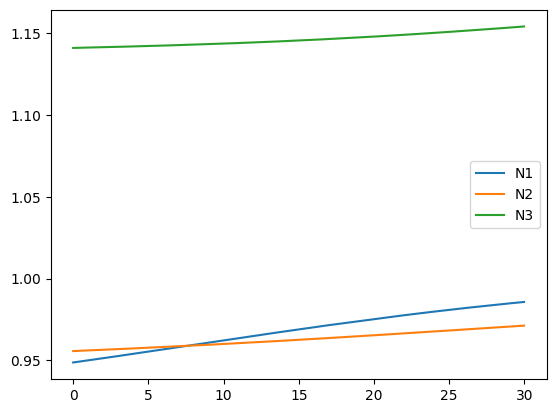

In [15]:
vectorized_u_init = vmap(lambda t: u(t, init_params), (0), 0)

plt.plot(
    train_data.times.sort(axis=0) * Tmax,
    vectorized_u_init(train_data.times.sort(axis=0))[:, 0],
    label="N1",
)
plt.plot(
    train_data.times.sort(axis=0) * Tmax,
    vectorized_u_init(train_data.times.sort(axis=0))[:, 1],
    label="N2",
)
plt.plot(
    train_data.times.sort(axis=0) * Tmax,
    vectorized_u_init(train_data.times.sort(axis=0))[:, 2],
    label="N3",
)

plt.legend()

## Loss construction

We construct a LossODE for GeneralizedLotkaVolterra

In [16]:
dynamic_loss = jinns.loss.GeneralizedLotkaVolterra(Tmax=Tmax)

In [17]:
loss_weights = jinns.loss.LossWeightsODE(dyn_loss=1, initial_condition=1 * Tmax)

loss = jinns.loss.LossODE(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=dynamic_loss,
    initial_condition=(tmin, N_0),
    params=init_params,
)

In [18]:
# Testing the loss function
train_data, batch = train_data.get_batch()

losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
losses, grads = losses_and_grad(init_params, batch)
l_tot, d = losses
print(f"total loss: {l_tot}")
print(f"Individual losses: { {key: f'{val}' for key, val in d.items()} }")

total loss: 4466.4443359375
Individual losses: {'dyn_loss': '(Array(667.46094, dtype=float32),)', 'initial_condition': '126.63278198242188'}


## Learning the neural network parameters

The learning process here considers known equation parameters `eq_params`. We thus only update `nn_params`.

In the following cells, we define the necessary object for optimization of the 
`loss` we just defined. Namely, an `optax.GradientTransformation` which is the optimizer we'll use for 
updating `params` throughout. Here it is simply Adam with an exponential weight decay.


In [19]:
params = init_params

In [20]:
# Optimizer
import optax

start_learning_rate = 1e-3
# Exponential decay of the learning rate.
scheduler = optax.exponential_decay(
    init_value=start_learning_rate,
    transition_begin=5000,
    transition_steps=100,
    decay_rate=0.99,
)

tx = optax.chain(
    optax.scale_by_adam(),  # Use the updates from adam.
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0),
)

In [21]:
n_iter = int(25000)

In [22]:
key, subkey = random.split(key)

In [23]:
params, total_loss_list, loss_by_term_dict, data, loss, _, _, _, _, _, _, _ = (
    jinns.solve(
        init_params=params, data=train_data, optimizer=tx, loss=loss, n_iter=n_iter
    )
)

Initialization time: 2.7756056785583496

Compilation took
 7.507396221160889 

[train] Iteration 0: loss value = 4466.54931640625
[train] Iteration 1000: loss value = 263.5889892578125
[train] Iteration 2000: loss value = 139.7888946533203
[train] Iteration 3000: loss value = 86.2763900756836
[train] Iteration 4000: loss value = 50.90586471557617
[train] Iteration 5000: loss value = 31.4503173828125
[train] Iteration 6000: loss value = 19.881622314453125
[train] Iteration 7000: loss value = 12.947985649108887
[train] Iteration 8000: loss value = 8.193131446838379
[train] Iteration 9000: loss value = 4.790513038635254
[train] Iteration 10000: loss value = 4.187946796417236
[train] Iteration 11000: loss value = 2.2976813316345215
[train] Iteration 12000: loss value = 1.2562413215637207
[train] Iteration 13000: loss value = 0.891116738319397
[train] Iteration 14000: loss value = 0.375885546207428
[train] Iteration 15000: loss value = 0.33718761801719666
[train] Iteration 16000: loss value

## Results

Plot the loss values

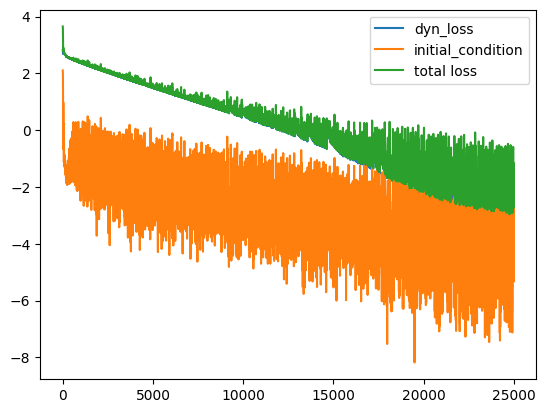

In [24]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show()

Plot the ODE solutions learned by the PINN

<Axes: xlabel='t'>

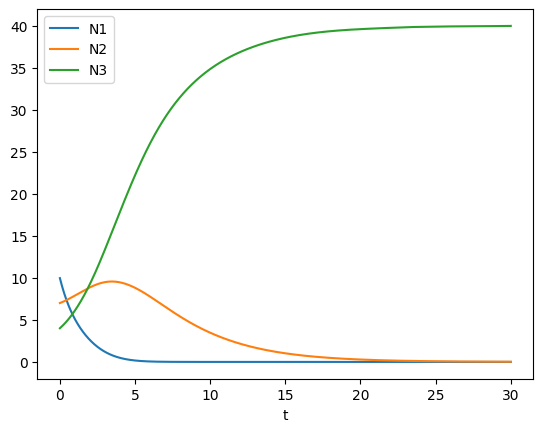

In [25]:
import pandas as pd

u_est = vmap(lambda t: u(t, params), (0), 0)

key, subkey = random.split(key, 2)
val_data = jinns.data.DataGeneratorODE(
    key=subkey, nt=nt, tmin=tmin, tmax=tmax, method=method
)

ts = val_data.times.sort(axis=0).squeeze()
df = pd.DataFrame(
    {
        "t": ts * Tmax,  # rescale time for plotting
        "N1": u_est(ts)[:, 0],
        "N2": u_est(ts)[:, 1],
        "N3": u_est(ts)[:, 2],
        "Method": "PINN",
    },
)
df.plot(x="t")

## Compare with the scipy solver
Code from Lorenzo Sala

In [26]:
import numpy as np
from scipy.integrate import odeint

# NOTE the following line is not accurate as it skips one batch


def lotka_volterra_log(y_log, t, eq_params):
    """
    Generalized Lotka-Volterra model for N bacterial species, with logarithmic transformation for stability.

    Parameters:
        y_log (array): Array of log-transformed bacterial populations.
        t (float): Time.
        params (tuple): Tuple of model parameters.

    Returns:
        dydt (array): Array of derivative of log-transformed bacterial populations with respect to time.
    """
    alpha, beta, gamma, _ = eq_params
    N = len(y_log)
    y = np.exp(y_log)
    dydt = np.zeros(N)

    for i in range(N):
        dydt[i] = y[i] * (
            alpha[i]
            - beta[i] * np.sum(y)
            - np.sum([gamma[j][i] * y[j] for j in range(N)])
        )

    dydt_log = dydt / y

    return dydt_log


# Define name bacteria
names = ["N1", "N2", "N3"]
N = len(names)

# Define model parameters
death_rates = None
eq_params = (growth_rates, carrying_capacities, interactions, death_rates)

# Define initial bacterial populations
y0 = [10, 7, 4]

# Define time points
Tmax = 30
t = ts * Tmax

############################

y0_log = np.log(y0)
y_log = odeint(lotka_volterra_log, y0_log, t, args=(eq_params,))
y = np.exp(y_log)

In [27]:
# comparative plots
df_scipy = pd.DataFrame(
    {
        "t": ts * Tmax,  # rescale time for plotting
        "Method": "Scipy solver",
    }
    | {f"N{i + 1}": y[:, i] for i in range(3)},
)

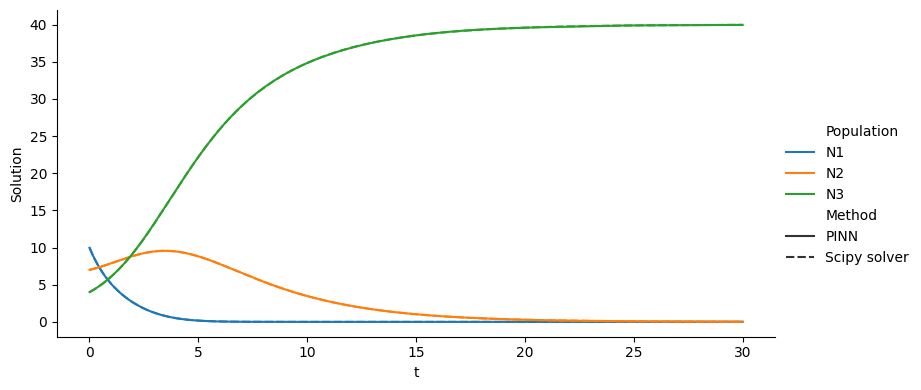

In [28]:
import seaborn as sns

df_plot = pd.concat((df, df_scipy)).melt(
    id_vars=["Method", "t"], var_name="Population", value_name="Solution"
)
sns.relplot(
    df_plot,
    kind="line",
    x="t",
    y="Solution",
    hue="Population",
    style="Method",
    height=4,
    aspect=2,
)

# Conclusion

We have shown how to use `LossODE` for system of ODEs. The results are satisfying although they could be improved by tweaking the network's architecture, learning rate and optimizers. Obviously, in the simple *forward problem* setting, the approach is not competitive compared to more standard and basic approaches. However, it paves the way for using PINN in an *inverse problem* when we have partial observation of the solution and wish to learn `params.eq_params`.